In [13]:
# Initial Model Fitting in PyGam
# PB 1/18/23

from pygam import LinearGAM, s
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Awesome package for non-linear correlation analysis
# should be really useful for feature selection
# https://www.sciencedirect.com/science/article/pii/S2352711021000315#fig2
# https://github.com/ElsevierSoftwareX/SOFTX-D-20-00028
from ennemi import pairwise_mi, pairwise_corr

# # # NOTES:

# NOTE: Just encountered a problem where the PAIsum_0m rows have infinity in them
# This is because from 5cm - 0m, many plots saturate
# How can we fix this?
# one way - cut out the 5 cm bin 
# and use PAI from 25 cm - 0 cm instead.
# this likely won't saturate as easilly
# 1/23/23

# NOTE: 1/23/2023 - Move the model fitting to R
# To use mgcv for more advanced GAM fitting

# TBD
# What does using canopy density as a percentage value mean for the model? Need to change distribution?
# Set up further model validation (cross validation)
# Do Herb H and Max/mean field height comparisons (correlation, regressions, etc.)

# # # USER INPUTS

# region = 'Mpala'
region = 'Kruger'

# SET unique label for this run (i.e. the date, "initial", "spicy", etc.)

# initial run, groundthres = 5 cm
# label = "initial" 

# Spicy corresponding to the one where metrics are calculated
# ONLY using the grass layer points, and groundthres = 2cm
label = "spicy" 


# # # END USER INPUTS

In [14]:
XYdf = pd.read_csv(f'./data/out/{label}/{region}/XYdata.csv')

# NOTE drop foliage height diversity - has nans for some reason
XYdf= XYdf.drop(columns = ['FHD'])

if region == 'Mpala':

    X = XYdf.drop(columns = ['Plot #', 'GPS #', 'Date Harvested', '% Cover', 'Height 1', 'Height 2',
           'Height 3', 'Height 4', 'Average Height', 'Wet Weight (g)',
           'Dry Weight (g)', 'Site', 'Type', 'Tree Species', 'Bag Size',
           'Average Bag Weight (g)', 'Wet Weight Without Bag (g)',
           'Dry Weight Without Bag (g)', 'Water Weight (g)', 'Max Height (cm)',
           'Max Height (m)', 'id', 'log(DryWeight)', 'featureid','Unnamed: 0'])

    y = XYdf[['Plot #', 'GPS #', 'Date Harvested', '% Cover', 'Height 1', 'Height 2',
           'Height 3', 'Height 4', 'Average Height', 'Wet Weight (g)',
           'Dry Weight (g)', 'Site', 'Type', 'Tree Species', 'Bag Size',
           'Average Bag Weight (g)', 'Wet Weight Without Bag (g)',
           'Dry Weight Without Bag (g)', 'Water Weight (g)', 'Max Height (cm)',
           'Max Height (m)', 'id', 'log(DryWeight)', 'featureid']]

if region == 'Kruger':
    
    X = XYdf.drop(columns = ['Plot #', 'Letter', 'GPS #', 'Date Harvested',
              'Site', '% Cover', 'Height 1', 'Height 2', 'Height 3', 'Height 4',
              'Dry Weight (g)', 'Location', 'Tree Species', 'DPM', 'Unnamed: 0',
              'featureid', 'id', 'log(DryWeight)'])
    

    y = XYdf[['Plot #', 'Letter', 'GPS #', 'Date Harvested',
              'Site', '% Cover', 'Height 1', 'Height 2', 'Height 3', 'Height 4',
              'Dry Weight (g)', 'Location', 'Tree Species', 'DPM', 'Unnamed: 0',
              'featureid', 'id', 'log(DryWeight)']]

In [15]:
# X.columns

In [16]:
# Checking for Nans
# X.loc[X.apply(lambda x: np.any(np.isnan(x)), axis=1)]
# X.apply(lambda x: np.any(np.isnan(x)), axis=0)

In [17]:
# ALSO, checking for infinity
# NOTE: need to Do something about rows with infinitiy
# X.apply(lambda x: np.any(np.isinf(x)), axis=0)
# X = X.loc[X.apply(lambda x: np.any(np.isinf(x)), axis=1)]

In [18]:
# Scale features
Xscaled = X.apply(lambda x: (x - np.mean(x)) / np.std(x))

# Add feature id back in (aka: mpala site) back in, as a factor
if region == 'Mpala':
    
    Xscaled = Xscaled.assign(featureid= y['featureid'])
    
else:
    
    Xscaled = Xscaled.assign(featureid= y['Plot #'])
    
Xscaled.columns

Index(['coverherb_0m', 'coverherb_5cm', 'cover_0m', 'cover_5cm', '0', '25',
       '50', '75', '98', '100', 'mean', 'std', 'nlayers', 'gapsize',
       'maxpeakh', 'ptoh', 'cscore', 'VDR', 'VDRpeak', 'meanpeakh', 'stdpeakh',
       'cvpeakh', 'herbh', 'PAIsum_0m', 'PAIsum_5cm', 'PAIsum_0mto1p5m',
       'PAIsum_5cmto1p5m', 'PAImean_0mto1p5m', 'PAImean_5cmto1p5m',
       'featureid'],
      dtype='object')

In [19]:
# Split a training and testing set
seed = 42

# Split training and test datasets (so they are consistent for both feature selection methods below)
# BOTH SITES
X_train, X_test, y_train, y_test = train_test_split(Xscaled,
                                                    y,
                                                    random_state=seed)


In [20]:
# Compute pairwise correlation using mututal information index
# Note - run this on the original DF with both x and y data in it 

# for now, dropping columns with infinity 1/23

# Print Top Variables in order
if region == 'Mpala':
    
    XYcorr = pd.concat([X, y['Dry Weight Without Bag (g)']], axis=1)
    XYcorr = XYcorr.drop(columns = ['PAIsum_0m', 'PAIsum_0mto1p5m', 'PAImean_0mto1p5m'])
    
    corr = pairwise_corr(XYcorr, drop_nan=True)
    print(corr.loc['Dry Weight Without Bag (g)'].sort_values(ascending=False))
    # corr.loc['log(DryWeight)'].sort_values(ascending=False)
    # corr.loc['Wet Weight Without Bag (g)'].sort_values(ascending=False)
    
if region == 'Kruger':
    
    XYcorr = pd.concat([X, y['Dry Weight (g)']], axis=1)
    XYcorr = XYcorr.drop(columns = ['PAIsum_0m', 'PAIsum_0mto1p5m', 'PAImean_0mto1p5m'])
    corr = pairwise_corr(XYcorr, drop_nan=True)
    print(corr.loc['Dry Weight (g)'].sort_values(ascending=False))


75                   0.872251
mean                 0.866394
98                   0.863663
50                   0.860228
25                   0.797185
std                  0.794367
cover_0m             0.774841
herbh                0.773367
coverherb_0m         0.739098
cover_5cm            0.718559
coverherb_5cm        0.706154
100                  0.663156
ptoh                 0.650141
0                    0.539622
cscore               0.477103
VDR                  0.333169
PAIsum_5cmto1p5m     0.306000
PAIsum_5cm           0.306000
PAImean_5cmto1p5m    0.306000
stdpeakh             0.055792
gapsize              0.027195
nlayers              0.026455
cvpeakh             -0.004721
VDRpeak             -0.004721
maxpeakh            -0.010948
meanpeakh           -0.012013
Dry Weight (g)            NaN
Name: Dry Weight (g), dtype: float64


In [ ]:
# KRUGER SPICY 1/24
# 75                   0.872251
# mean                 0.866394
# 98                   0.863663
# 50                   0.860228
# 25                   0.797185
# std                  0.794367
# cover_0m             0.774841
# herbh                0.773367
# coverherb_0m         0.739098
# cover_5cm            0.718559

In [ ]:
# MPALA SPPICY 1/24
# 100                           0.804155
# 98                            0.784037
# 75                            0.760976
# std                           0.750670
# mean                          0.744222
# coverherb_5cm                 0.729503
# cover_5cm                     0.726991
# 50                            0.715745
# PAIsum_5cm                    0.701315
# PAImean_5cmto1p5m             0.701315
# PAIsum_5cmto1p5m              0.701315
# meanpeakh                     0.701067

In [ ]:
# KRUGER - top pairwise corr - 1/23
# cover_5cm            0.865090
# herbh                0.864227
# coverherb_5cm        0.863829
# Height 4             0.842344
# PAIsum_5cm           0.818907
# 50                   0.812874
# 25                   0.811870
# mean                 0.799406
# PAImean_5cmto1p5m    0.797188
# PAIsum_5cmto1p5m     0.797188
# 75                   0.791930
# cover_0m             0.739724

In [6]:
# Mpala - top pairwise corr - 1/23/23
# Looks like the best (for non-logged dry-weight data) are:
# mean                          0.772619
# PAImean_5cmto1p5m             0.764521
# PAIsum_5cmto1p5m              0.764521
# cover_5cm                     0.758918
# 100                           0.754938
# 50                            0.737616
# PAIsum_5cm                    0.736337
# 98                            0.735278
# 75                            0.730519
# coverherb_5cm                 0.727583
# 25                            0.719528
# std                           0.689772
# herbh                         0.662953

In [ ]:
# Top non-logged Wet Weight
# mean                          0.767734
# cover_5cm                     0.758918
# Average Bag Weight (g)        0.750506
# 100                           0.746070
# PAIsum                        0.742186
# 50                            0.731141
# coverherb_5cm                 0.727583
# 98                            0.725110
# 75                            0.722333
# FHD                           0.713418
# 25                            0.710809

In [ ]:
# Top logged Dry weight
# mean                          0.818148
# Height 4                      0.816014
# Height 3                      0.815961
# 75                            0.794731
# 98                            0.791069
# 50                            0.784541
# 100                           0.782734
# PAIsum                        0.763150
# Average Bag Weight (g)        0.755508
# cover_5cm                     0.751354
# std                           0.745806
# FHD                           0.736128
# coverherb_5cm                 0.723310

In [55]:
# corr.loc['mean'].sort_values(ascending=False)

In [67]:
# Let's GAM!
# Dry Weights 

X_m1 = X_train[['mean', 'coverherb_5cm']]
y_m1 = y_train['Dry Weight Without Bag (g)']
gam = LinearGAM(s(0) + s(1)).fit(X_m1, y_m1)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     15.7998
Link Function:                     IdentityLink Log Likelihood:                                 -1132.3621
Number of Samples:                          128 AIC:                                             2298.3239
                                                AICc:                                             2303.751
                                                GCV:                                             3551.6941
                                                Scale:                                           2772.4384
                                                Pseudo R-Squared:                                   0.7382
Feature Function                  Lam

C:\Users\peter\AppData\Local\Temp\ipykernel_39560\1532544153.py:7: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [92]:
# Calculate MSE and plot residuals
# Using training and test dataset

yfit = gam.predict(X_m1)

yfit_PI = gam.prediction_intervals(X_m1)


ValueError: 'x' and 'y' must have the same size

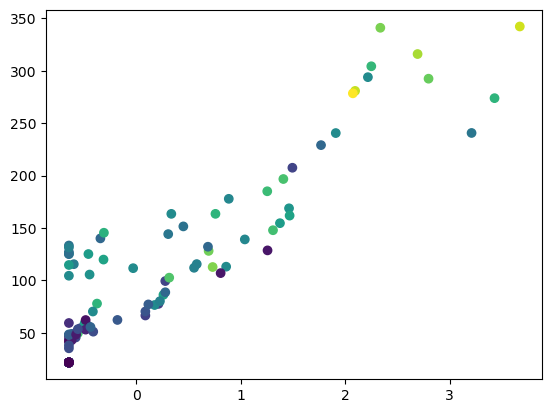

In [93]:

# Plot x vars against y with pred intervals
fig, ax = plt.subplots()
ax.scatter(X_m1['coverherb_5cm'], yfit, c=y_train['Max Height (m)'])
ax.scatter(X_m1['coverherb_5cm'], yfit_PI[0], yfit_PI[1])

ValueError: 'x' and 'y' must have the same size

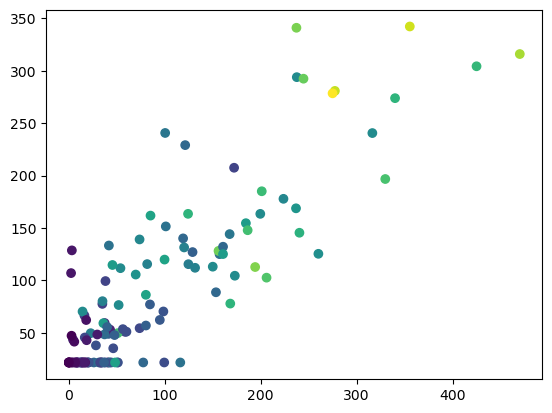

In [89]:

fig, ax = plt.subplots()
ax.scatter(y_m1, yfit, c=y_train['Max Height (m)'])
ax.set_xlabel('Observed Dry Biomass [g]')
ax.set_ylabel('Predicted Dry Biomass [g]')
# ax.set_xlim(0, 100)

# Lots of low biomass values being predicted as 0

Text(0, 0.5, 'Dry Biomass [g]')

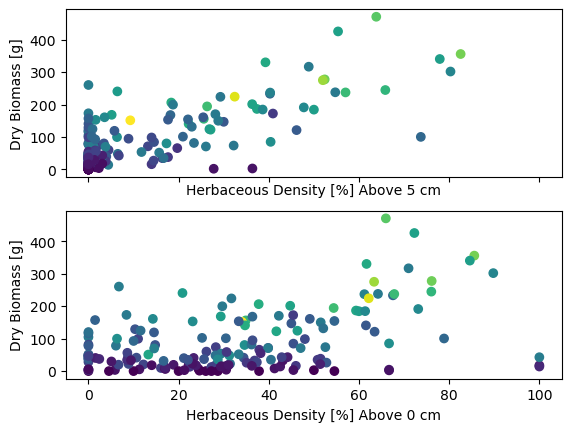

In [64]:
# Interesting that there's a lot issues with the lower biomass grass plots
# Probably has to do with cover values saturating at low levels
# maybe need to use cover above 0 m

fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)
ax.scatter(XYdf['coverherb_5cm']*100, XYdf['Dry Weight Without Bag (g)'], c=XYdf['Max Height (m)'])
ax2.scatter(XYdf['coverherb_0m']*100, XYdf['Dry Weight Without Bag (g)'], c=XYdf['Max Height (m)'])
ax.set_xlabel('Herbaceous Density [%] Above 5 cm')
ax2.set_xlabel('Herbaceous Density [%] Above 0 cm')
ax.set_ylabel('Dry Biomass [g]')
ax2.set_ylabel('Dry Biomass [g]')

In [12]:
# Let's GAM!
# Wet Weights 

X = XYdf[['mean', 'PAIsum']]
y = XYdf[['Wet Weight Without Bag (g)']]
gam = LinearGAM(s(0) + s(1)).fit(X, y)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     15.0569
Link Function:                     IdentityLink Log Likelihood:                                 -1546.5027
Number of Samples:                          171 AIC:                                             3125.1192
                                                AICc:                                            3128.6774
                                                GCV:                                             4006.8023
                                                Scale:                                            3377.198
                                                Pseudo R-Squared:                                   0.6969
Feature Function                  Lam

C:\Users\peter\AppData\Local\Temp\ipykernel_39560\2332594898.py:7: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [ ]:
# Log Model 
# X = XYdf[['mean', 'coverherb_5cm']]
# y = XYdf[['log(DryWeight)']]
# gam = LinearGAM(s(0) + s(1)).fit(X, y)
# gam.summary()

In [8]:
# Partial Dependence plots
# NOTE: Code Pulled directly from the gam site
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

NameError: name 'plt' is not defined

In [ ]:
# Do a gridspace search 
# Also taken directly from pyGam website

lam = np.logspace(-3, 5, 5)
# lam = np.array([0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1])
lams = [lam] * 2
# https://pygam.readthedocs.io/en/latest/notebooks/quick_start.html#Fit-a-Model
gam = LinearGAM(s(0) + s(1)).gridsearch(X, y, lam=lams)
gam.summary()
